In [4]:
!git clone https://github.com/ruthenian8/from-numpy-import-Neural-Network.git ./libs;

Cloning into './libs'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 26 (delta 8), reused 16 (delta 2), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [13]:
!cp -r libs/our_library .

In [ ]:
!pip install -r libs/requirements.txt

In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

# Домашка №1
# Усложненная
### Эта домашка нужна для лучшего понимания, но она будет сложнее из-за использования классов и, возможно, пока непривычной форме с классами.
Абстракции в этой домашке будут очень полезны для понимания того, что происходит в торче. Эта домашка прокачает вас гораздо сильнее, но и выполнить ее будет труднее. Вам нужно будет описать несколько слоев: `Linear`, `ReLU`, `BCELoss`.  Реализация `Sigmoid` уже есть в `our_library.layers`. Реализовав слои выше вы сможете сделать n-слойную нейронную сеть с любым количеством слоев. Это получается за счет того, что вы описали всю необходимую логику:
- Как нужно обработать входные данные и передать их дальше;
- Принять градиент с последующего слоя, сделать `backward` для текущего слоя и передать градиент предыдущему слою;
- Как обновить веса, если в слоев есть обучаемые веса.

Присылайте свои недоделанные сложные домашки, пусть они не пойдут совсем в стол. Я или ассистенты посмотрят, мы обсудим и доделаем.  
Поверьте, эта домашка стоит того, чтобы ее сделать!

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Некоторые магические трансформации, о которых пока не стоит заморачиваться
1. Перевод картинки в тензор
1. Нормализация картинки

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет
Конкретно эта часть кода понадобится нам один раз за курс и будет только в этой домашке

In [3]:
train_dataset = MNIST('.', train=True, download=False, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Переводим его в два класса
Это нужно для упрощения задачи до бинарной классификации. В этой домашке мы будем отличать две цифры: 1 и 7.

In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных
Далее в курсе мы поговорим о том, что это такое более подробно, а дальше в этой тетрадке будет несколько полезных деталей.  
Пока что будет достаточно понимать, что мы обернули наши данные в некоторую абстракцию, итерация по которой дает нам батчи данных из нашего датасета.  

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7  

Выбрал эти цифры, потому что на них хуже всего метрики

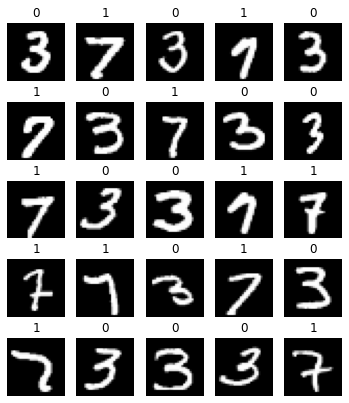

In [10]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Итерация по датасету
- x - батч с данными
- y - батч с таргетами к этим данным

In [11]:
for x, y in train_loader:
    break

### train_loader это итератор, при проходе по которому будут выдаваться батчи данных

## Размерность x
- 128 - размер батча
- 1 - количество каналов, у нас чернобелые картинки, поэтому канал 1
- 28 - количество пикселей в длину
- 28 - количество пикселей в ширину

In [12]:
x.shape

torch.Size([128, 1, 28, 28])

In [13]:
x

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

## Просто выпрямим нашу матрицу в один вектор
### То есть каждая фича в векторе это значение пикселя
### Для нашей игрушечной задачи этого будет достаточно

In [14]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

### x.numpy()
Это перевод торчового тензора (некоторая абстракция, о которой мы будем говорить позже на курсе) в numpy массив

In [15]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

In [ ]:
x

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

### Размерность
- количество примеров в батче
- количество фичей

In [16]:
x.shape

(128, 784)

# Таргеты
- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7

In [ ]:
y

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1])

# Итерация по эпохам

In [18]:
# количество эпох - полных проходов по датасету
epochs = 3

for n_epoch in range(epochs):
    
    dataset_passed_samples = 0
    
    for x, y in train_loader:
        
        # вот здесь мы могли бы как-то манипулировать с данными
        # например, учить, но пока этого делать не будет
        # только демонстрация
        
        time.sleep(0.01)
        
        dataset_passed_samples += x.shape[0]
        
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]
        
        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')
        
    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Небольшие пояснения по numpy

In [21]:
# таким образом мы создаем матрицу 64 на 512 с рандомными значениями
x = np.random.rand(64, 512)
x

array([[0.37846012, 0.64417364, 0.69744862, ..., 0.13058401, 0.43481787,
        0.379522  ],
       [0.1813972 , 0.44467892, 0.01656831, ..., 0.2510146 , 0.19282195,
        0.68315399],
       [0.52621401, 0.87372568, 0.8923658 , ..., 0.09673485, 0.46318319,
        0.53828531],
       ...,
       [0.40442187, 0.14899443, 0.08700152, ..., 0.30977443, 0.12612339,
        0.7683909 ],
       [0.88952276, 0.07256167, 0.03199743, ..., 0.03484155, 0.93522924,
        0.32811458],
       [0.39243644, 0.20847713, 0.54492239, ..., 0.82878945, 0.8466631 ,
        0.27693667]])

In [22]:
# большинство функций применяются к каждому элементу массива
# здесь мы каждый элемент массива возвели в квадрат и прибавили к получившемуся значению логарифм элемента матрицы 
x ** 2 + np.log(x)

array([[-0.82841251, -0.02482728,  0.12610816, ..., -2.0186863 ,
        -0.64376144, -0.82480578],
       [-1.67416121, -0.61266343, -4.09998877, ..., -1.31923586,
        -1.60880774,  0.08566439],
       [-0.36514611,  0.62840776,  0.68243758, ..., -2.32642393,
        -0.55509397, -0.32961546],
       ...,
       [-0.74173965, -1.88164701, -2.43426043, ..., -1.07595069,
        -2.05458748,  0.32696789],
       [ 0.67418056, -2.61805328, -3.44107583, ..., -3.35573066,
         0.80769013, -1.00673321],
       [-0.78137434, -1.52446324, -0.31017149, ...,  0.49910282,
         0.55038599, -1.20727249]])

In [23]:
y = np.random.rand(512, 1024)
# скалярное произведение
res = np.dot(x, y)

In [45]:
res.shape

(64, 1024)

In [25]:
res.shape == (x.shape[0], y.shape[1])

True

# Импортируем нашу библиотеку
В ней реализованы некоторые полезные методы, в модуле `layers` есть реализация сигмоиды. Остальное вам смотреть необязательно, это некоторые дополнения, упрощающие вам жизнь.

In [26]:
from our_library import layers, wrapper, tools

## Реализуйте слои:
- Linear - линейная трансформация (не забудьте, что у нас в этом слое как раз есть обучаемые параметры)
- ReLU
- BCELoss - Binary Cross Entropy


## Вы можете реализовать как здесь, так и в файла layers

- TIP: np.expand_dims(y, 1) для BCE, так как BCE на вход принимает просто вектор размерностью (батч сайз, 1)

## Также внутри layers есть код для Negative Log-Likelihood (сразу с софтмаксом) для примера

# Пример c сигмоидой
В `our_library.layers` также это есть

In [27]:
class Sigmoid:

    def __init__(self):

        self._sigmoid_result = None

    def forward(self, x):

        self._sigmoid_result = 1 / (1 + np.exp(-x))

        return self._sigmoid_result

    def backward(self, grad):
        """
        :grad: градиент от предыдущего слоя
        :return: градиент для следующего слоя
        """

        new_grad = self._sigmoid_result * (1 - self._sigmoid_result) * grad

        return new_grad

    def step(self, learning_step):

        pass

# Тестирование

In [28]:
x = np.array([[0.91551091, 0.15073826, 0.77137556, 0.59352491],
              [0.81126142, 0.1194849 , 0.29651178, 0.19066982]])

correct_forward_result = np.array([[0.71412654, 0.53761337, 0.68381838, 0.64417351],
                                   [0.69237824, 0.52983574, 0.57358957, 0.54752357]])

correct_backward_result = np.array([[0.20414982, 0.24858523, 0.2162108 , 0.229214  ],
                                    [0.21299061, 0.24910983, 0.24458457, 0.24774151]])

In [29]:
sigmoid_layer = Sigmoid()
forward_result = sigmoid_layer.forward(x)
backward_result = sigmoid_layer.backward(np.ones_like(x))

In [30]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward_result)

In [31]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward_result)

In [93]:
this = np.array([[0.00879391, 0.0075844 , 0.00430709],
                          [0.00884834, 0.00921104, 0.00044317],
                          [0.00011441, 0.00822498, 0.00122346],
                          [0.00338301, 0.0001627 , 0.00711473]])

In [61]:
this = torch.tensor(np.random.rand(3, 4), requires_grad=True)

In [64]:
this.grad

# Линейный слой

In [82]:
class Linear:

    def __init__(self, in_features, out_features):
        
        # инициализируем веса
        self.weight = np.random.rand(in_features, out_features) * 0.01
        self.bias = np.zeros(out_features,)
        
        # сохраняем градиент для весов
        self._grad_weight = None
        self._grad_bias = None

    def forward(self, x):
        return np.dot(x, self.weight) + self.bias

    def backward(self, grad):
        backward_result = np.dot(previous_grad, np.transpose(this))
        self._grad_weight = 
        self._grad_bias = 
        return backward_result

    def step(self, learning_rate):
        self.weight = self.weight - self._grad_weight * learning_rate
        self.bias = self.bias - self._grad_bias * learning_rate

# Тестирование

In [89]:
correct_forward_result = np.array([[0.01148086, 0.01477317, 0.00917651],
                                   [0.00887036, 0.00972334, 0.00526646]])

previous_grad = np.array([[0.01595814, 0.85148336, 0.9980065 ],
                          [0.73044998, 0.18287682, 0.41246361]])

correct_backward_result = np.array([[0.01089683, 0.00842654, 0.00822628, 0.00729307],
                                    [0.00958704, 0.00833055, 0.00209236, 0.00543544]])

correct_grad_weight = np.array([[0.60719574, 0.92790321, 1.24830165],
                                [0.08968325, 0.15020214, 0.19972094],
                                [0.22889674, 0.71103859, 0.89213814],
                                [0.14874632, 0.54024567, 0.67098608]])

correct_grad_bias = np.array([0.74640812, 1.03436018, 1.41047011])

In [83]:
linear = Linear(in_features=4, out_features=3)

In [85]:
# так как внутри слоя мы объвяляем наши веса рандомно (домножая на 0.01), то давайте присвоим им для теста конкретные значения

linear.weight = np.array([[0.00879391, 0.0075844 , 0.00430709],
                          [0.00884834, 0.00921104, 0.00044317],
                          [0.00011441, 0.00822498, 0.00122346],
                          [0.00338301, 0.0001627 , 0.00711473]])

linear.bias = np.array([0., 0., 0.])

In [86]:
forward = linear.forward(x)
# backward = linear.backward(previous_grad)

In [96]:
np.dot(previous_grad, np.transpose(this))

array([[0.01089683, 0.00842654, 0.00822628, 0.00729307],
       [0.00958704, 0.00833055, 0.00209236, 0.00543544]])

In [ ]:
# значения должны быть близкими
# assert np.allclose(correct_forward_result, forward)

In [ ]:
# значения должны быть близкими
# assert np.allclose(correct_backward_result, backward)

In [ ]:
# значения должны быть близкими
# assert np.allclose(linear._grad_weight, correct_grad_weight)

In [ ]:
# значения должны быть близкими
# assert np.allclose(linear._grad_bias, correct_grad_bias)

In [75]:
a * b.astype(np.int_)

array([0, 0, 3, 4, 0])

# ReLU

In [97]:
class ReLU:

    def __init__(self):
        self._mask = None

    def forward(self, x):
        positive = x > 0
        self._mask = positive.astype(np.int_)
        return x * self._mask

    def backward(self, prev_grad):
        return prev_grad * self._mask

    def step(self, learning_rate):
        pass

# Тестирование

In [98]:
x = np.array([[ 0.86811233, -0.23718669, -0.18401917, -0.37591633],
              [-0.40626018,  0.37746975, -0.46929233,  0.79067681]])

correct_forward_result = np.array([[0.86811233, 0.        , 0.        , 0.        ],
                                   [0.        , 0.37746975, 0.        , 0.79067681]])

previous_grad = np.array([[0.22436157, 0.61897707, 0.67895832, 0.72428618],
                          [0.71231319, 0.87345215, 0.91129578, 0.90625846]])

correct_backward_result = np.array([[0.22436157, 0.        , 0.        , 0.        ],
                                    [0.        , 0.87345215, 0.        , 0.90625846]])

In [99]:
relu = ReLU()

In [100]:
forward = relu.forward(x)
backward = relu.backward(previous_grad)

In [102]:
#значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [103]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

# BCE test

In [104]:
1 - np.array([0,1,0])

array([1, 0, 1])

### Не забудьте добавить np.expand_dims(y, 1) в forward

In [168]:
class BCELoss:
    def __init__(self):
        self._x = None
        self._y = None
        self._BCE = None

    def forward(self, x, y):
        y = np.expand_dims(y, 1)
        self._x = x
        self._y = y
        self._BCE = - np.mean(np.log(x) * y + np.log(1 - x) * (1 - y))
        return self._BCE

    def backward(self):
        return (self._x - self._y) / self._y.shape[0]

    def step(self, learning_rate):
        pass

# Тестирование

In [147]:
x = np.array([[0.76242307],
              [0.0908412 ],
              [0.60176646],
              [0.09606798]])

y = np.array([1, 0, 1, 0])

correct_forward_result = 0.24384403491500606

correct_backward_result = np.array([[-0.32790194],
                                    [ 0.27497946],
                                    [-0.41544356],
                                    [ 0.27656947]])

In [169]:
loss = BCELoss()

In [171]:
loss.forward(x, y)

0.24384403491500606

In [173]:
loss.backward()

array([[-0.05939423],
       [ 0.0227103 ],
       [-0.09955838],
       [ 0.02401699]])

In [149]:
forward = loss.forward(x, y)
# backward = loss.backward()

In [ ]:
# значения должны быть близкими
# assert np.allclose(correct_forward_result, forward)

In [ ]:
# значения должны быть близкими
# assert np.allclose(correct_backward_result, backward)

## Реализуйте обертку над слоями - нейронную сеть
- TIP 1: modules - это список слоев, которые вы сделали выше. Порядок важен
- TIP 2: обновление весов можно сделать циклом
- TIP 3: forward идет в одну сторону по слоям, а backward в другую
- TIP 4: В backward функции потерь мы не передаем предыдущий градиент, потому что это начало backward, то есть последний слой нашей сети
- TIP 5: forward и backward ничего не должны отдавать, в них должны быть расчитаны градиенты для каждого слоя
- TIP 6: в step нужно пройтись по всем слоям и обновить веса

In [ ]:
class NeuralNetwork:

    def __init__(self, modules):

        # список слоев
        self.modules = modules

    def forward(self, x):
        ...

    def backward(self, grad):
        """
        :grad: градиент от функции потерь
        :return: возвращать ничего не потребуется
        """
        ...

    def step(self, learning_rate):
        ...

## Реализуйте обертку над моделью

In [ ]:
class MNISTWrapper(wrapper.Wrapper):

    def train_batch(self, x, y):
        """
        Нужно реализовать одну итерацию обучения модели:
        1. Рассчет forward
        2. Рассчет функции потерь
        3. Рассчет backward от функции потерь
        4. Рассчет backward по модели, передавая туда значение градиента по функции потерь
        5. Обновление весов с помощью step
        :param x: входные данные np.array with shape (batch_size, n_features)
        :param y: предсказания np.array with shape (batch_size, n_classes)
        :return:
        loss_batch - значение функции потерь, просто скаляр
        prediction - матрица предсказаний вашей модели

        напомню важные штуки, которые знает наш класс:
        self.model
        self.loss
        self.learning_rate
        """
        # КОД ЗДЕСЬ
        prediction = self.model(x)
        loss = self.loss(x, y)

In [ ]:
# задайте гиперпараметры
learning_rate = 0.01
epochs = 12

# задайте слои в свою нейронную сеть, например, 3 слоя
neural_network = layers.NeuralNetwork(...)

loss = BCELoss()

In [ ]:
classifier = MNISTWrapper(model=neural_network,
                          loss=loss,
                          learning_rate=learning_rate)

## Обучение модели

In [ ]:
classifier.train(train_loader, test_loader, epochs=epochs)

In [ ]:
classifier.plot()